In [ ]:
import os
import numpy as np
import cv2
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import layers, Model, optimizers, Sequential
from keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import itertools
from collections import defaultdict

In [ ]:
class SiameseVGG16:
  def __init__(self, input_shape = (128, 128, 3)):
    self.input_shape = input_shape
    self.model = None
    self.history = None
    self._is_compiled = False

  def create_base_network(self):
    base_model = VGG16(weights = 'imagenet', include_top = False, input_shape = self.input_shape)

    for layer in base_model.layers[:-4]:
      layer.trainable = False

    model = Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation = 'relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation = 'relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation = 'relu')
    ])
    return model

  def build_siamese_network(self):
    base_network = self.create_base_network()

    input_a = layers.Input(shape = self.input_shape)
    input_b = layers.Input(shape = self.input_shape)

    encoded_a = base_network(input_a)
    encoded_b = base_network(input_b)

    l1_distance = layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([encoded_a, encoded_b])

    prediction = layers.Dense(64, activation = 'relu')(l1_distance)
    prediction = layers.Dropout(0.3)(prediction)
    prediction = layers.Dense(32, activation = 'relu')(prediction)
    prediction = layers.Dense(1, activation = 'sigmoid')(prediction)

    self.model = Model(inputs = [input_a, input_b], outputs = prediction)
    self._is_compiled = False

  def load_and_preprocess_data(self, data_path):
    wanted_path = os.path.join(data_path, 'wanted')
    unwanted_path = os.path.join(data_path, 'unwanted')

    wanted_images = {}
    unwanted_images = {}

    for person_folder in os.listdir(wanted_path):
      person_path = os.path.join(wanted_path, person_folder)
      if os.path.isdir(person_path):
        images = []
        for img_file in os.listdir(person_path):
          if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.jfif')):
            img_path = os.path.join(person_path, img_file)
            img = cv2.imread(img_path)
            if img is not None:
              img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
              img = cv2.resize(img, self.input_shape[:2])
              img = img.astype('float32') / 255.0
              images.append(img)
        wanted_images[person_folder] = images

    for person_folder in os.listdir(unwanted_path):
      person_path = os.path.join(unwanted_path, person_folder)
      if os.path.isdir(person_path):
        images = []
        for img_file in os.listdir(person_path):
          if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.jfif')):
            img_path = os.path.join(person_path, img_file)
            img = cv2.imread(img_path)
            if img is not None:
              img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
              img = cv2.resize(img, self.input_shape[:2])
              img = img.astype('float32') / 255.0
              images.append(img)
        unwanted_images[person_folder] = images

    return wanted_images, unwanted_images

  def create_pairs_enhanced(self, wanted_images, unwanted_images, augmentation_factor = 2, negative_multiplier = 3):
    pairs_a = []
    pairs_b = []
    labels = []

    positive_count = 0

    for person_id, images in wanted_images.items():
      if len(images) >= 2:
        for i in range(len(images)):
          for j in range(i + 1, len(images)):
            pairs_a.append(images[i])
            pairs_b.append(images[j])
            labels.append(1)
            positive_count += 1

    for person_id, images in unwanted_images.items():
      if len(images) >= 2:
        for i in range(len(images)):
          for j in range(i + 1, len(images)):
            pairs_a.append(images[i])
            pairs_b.append(images[j])
            labels.append(1)
            positive_count += 1

    print(f"Positive pairs created: {positive_count}")

    if augmentation_factor > 1:
      print(f"Augmenting positive pairs with factor {augmentation_factor}")
      datagen = ImageDataGenerator(
          rotation_range = 15,
          width_shift_range = 0.15,
          height_shift_range = 0.15,
          horizontal_flip = True,
          zoom_range = 0.15,
          brightness_range = [0.8, 1.2],
          fill_mode = 'nearest'
      )

      original_positive_pairs = positive_count
      for aug_iter in range(augmentation_factor - 1):
        print(f"Augmentation iteration {aug_iter + 1}/{augmentation_factor - 1}")
        for i in range(original_positive_pairs):
          img_a = pairs_a[i].reshape((1,) + pairs_a[i].shape)
          img_b = pairs_b[i].reshape((1,) + pairs_b[i].shape)

          aug_a = next(datagen.flow(img_a, batch_size = 1))[0]
          aug_b = next(datagen.flow(img_b, batch_size = 1))[0]

          pairs_a.append(aug_a)
          pairs_b.append(aug_b)
          labels.append(1)

      print(f"Total positive pairs after augmentation: {len([l for l in labels if l == 1])}")

      all_wanted_with_ids = []
      all_unwanted_with_ids = []

      for person_id, images in wanted_images.items():
        for img in images:
          all_wanted_with_ids.append((person_id, img))

      for person_id, images in unwanted_images.items():
        for img in images:
          all_unwanted_with_ids.append((person_id, img))

      # calculate current positive count (after augmentation)
      current_positive_count = len([l for l in labels if l == 1])
      num_negative_target = current_positive_count * negative_multiplier
      negative_count = 0

      # different: wanted vs unwanted
      cross_category_pairs = min(num_negative_target // 3,
                                 len(all_wanted_with_ids) * len(all_unwanted_with_ids))
      for _ in range(cross_category_pairs):
        person1_id, img1 = random.choice(all_wanted_with_ids)
        person2_id, img2 = random.choice(all_unwanted_with_ids)
        pairs_a.append(img1)
        pairs_b.append(img2)
        labels.append(0)
        negative_count += 1

      # different: wanted vs wanted
      wanted_persons = list(wanted_images.keys())
      if len(wanted_persons) > 2:
        max_wanted_pairs = sum([len(wanted_images[p1]) * len(wanted_images[p2])
        for p1, p2 in itertools.combinations(wanted_persons, 2)])
        wanted_negative_pairs = min(num_negative_target // 3, max_wanted_pairs)

        for _ in range(wanted_negative_pairs):
          person1, person2 = random.sample(wanted_persons, 2)
          if wanted_images[person1] and wanted_images[person2]:
            img1 = random.choice(wanted_images[person1])
            img2 = random.choice(wanted_images[person2])
            pairs_a.append(img1)
            pairs_b.append(img2)
            labels.append(0)
            negative_count += 1

      # different: unwanted vs unwanted
      unwanted_persons = list(unwanted_images.keys())
      if len(unwanted_persons) >= 2:
            max_unwanted_pairs = sum([len(unwanted_images[p1]) * len(unwanted_images[p2])
                                      for p1, p2 in itertools.combinations(unwanted_persons, 2)])
            unwanted_negative_pairs = min(num_negative_target // 3, max_unwanted_pairs)

            print(f"  Creating {unwanted_negative_pairs} unwanted vs unwanted pairs...")
            for _ in range(unwanted_negative_pairs):
                person1, person2 = random.sample(unwanted_persons, 2)
                if unwanted_images[person1] and unwanted_images[person2]:
                    img1 = random.choice(unwanted_images[person1])
                    img2 = random.choice(unwanted_images[person2])
                    pairs_a.append(img1)
                    pairs_b.append(img2)
                    labels.append(0)
                    negative_count += 1

      print(f"Negative pairs created: {negative_count}")
      print(f"Total pairs: {len(labels)}")
      print(f"Positive/Negative ratio: {current_positive_count}/{negative_count} = {current_positive_count/negative_count:.2f}")

      return np.array(pairs_a), np.array(pairs_b), np.array(labels)


  def train(self, data_path, epochs = 20, batch_size = 32, use_enhanced_pairs = True, augmentation_factor = 2, negative_multiplier = 3):
        wanted_images, unwanted_images = self.load_and_preprocess_data(data_path)

        if use_enhanced_pairs:
          pairs_a, pairs_b, labels = self.create_pairs_enhanced(
              wanted_images, unwanted_images,
              augmentation_factor = augmentation_factor,
              negative_multiplier = negative_multiplier
          )
        else:
          pass

        X_train_a, X_val_a, X_train_b, X_val_b, y_train, y_val = train_test_split(
            pairs_a, pairs_b, labels,
            test_size = 0.2,
            random_state = 42,
            stratify = labels
        )

        print(f"\nTraining set: {len(y_train)} pairs")
        print(f"Validation set: {len(y_val)} pairs")

        if self.model is None:
          self.build_siamese_network()

        if not self._is_compiled:
          print("Model has not been compiled. Compiling now...")

          initial_lr = 0.001
          lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
              initial_learning_rate = initial_lr,
              decay_steps = 100,
              decay_rate = 0.9,
              staircase = True
          )

          self.model.compile(
              optimizer = optimizers.Adam(learning_rate = lr_schedule),
              loss = 'binary_crossentropy',
              metrics = ['accuracy']
          )
          self._is_compiled = True
        else:
          print("Model is already compiled. Skipping compilation")

        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor = 'val_accuracy',
                patience = 15,
                mode = 'max',
                restore_best_weights = True,
                verbose = 1
            ),
            tf.keras.callbacks.EarlyStopping(
                monitor = 'val_loss',
                patience = 20,
                mode = 'min',
                restore_best_weights = False,
                verbose = 1
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor = 'val_loss',
                factor = 0.5,
                patience = 5,
                min_lr = 1e-7,
                verbose = 1
            ),
            tf.keras.callbacks.ModelCheckpoint(
                'best_siamese_vgg_lightweight.h5',
                monitor = 'val_accuracy',
                save_best_only = True,
                mode = 'max',
                verbose = 1
            ),
            tf.keras.callbacks.TensorBoard(
                log_dir = './logs',
                histogram_freq = 1,
                write_graph = True
            )
        ]

        print("\n=== Starting Training ===")
        self.history = self.model.fit(
            [X_train_a, X_train_b], y_train,
            validation_data = ([X_val_a, X_val_b], y_val),
            epochs = epochs,
            batch_size = batch_size,
            callbacks = callbacks,
            verbose = 1
        )

        return X_val_a, X_val_b, y_val

  def fine_tune(self, data_path, epochs = 20, batch_size = 32, use_enhanced_pairs = True, augmentation_factor = 2, negative_multiplier = 3, fine_tune_lr = 1e-5):
    wanted_images, unwanted_images = self.load_and_preprocess_data(data_path)
    pairs_a, pairs_b, labels = self.create_pairs_enhanced(
        wanted_images, unwanted_images, augmentation_factor = augmentation_factor, negative_multiplier = negative_multiplier
    )

    X_train_a, X_val_a, X_train_b, X_val_b, y_train, y_val = train_test_split(
        pairs_a, pairs_b, labels,
        test_size = 0.2,
        random_state = 42,
        stratify = labels
    )
    self.model.compile(optimizers.Adam(learning_rate = fine_tune_lr),
                       loss = 'binary_crossentropy',
                       metrics = ['accuracy'])
    self._is_compiled = True

    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor = 'val_accuracy',
            patience = 25,
            mode = 'max',
            restore_best_weights = True,
            verbose = 1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor = 'val_loss',
            factor = 0.5,
            patience = 5,
            min_lr = 1e-8,
            verbose = 1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            'best_siamese_vgg_finetuned.h5',
            monitor = 'val_accuracy',
            save_best_only = True,
            mode = 'max',
            verbose = 1
        ),
        tf.keras.callbacks.TensorBoard(
            log_dir = './logs_finetune',
            histogram_freq = 1,
            write_graph = True
        )
    ]

    self.history = self.model.fit(
        [X_train_a, X_train_b], y_train,
        validation_data = ([X_val_a, X_val_b], y_val),
        epochs = epochs,
        batch_size = batch_size,
        callbacks = callbacks,
        verbose = 1
    )

    return X_val_a, X_val_b, y_val

  def evaluate_model(self, X_val_a, X_val_b, y_val):
        y_pred_prob = self.model.predict([X_val_a, X_val_b])
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()

        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        auc_roc = roc_auc_score(y_val, y_pred_prob)

        print('*** Siamese Network (VGG16 based) results ***')
        print(f'Accuracy: {accuracy:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1-Score: {f1:.4f}')
        print(f'AUC-ROC: {auc_roc:.4f}')

        self.plot_training_history()
        self.plot_confusion_matrix(y_val, y_pred)
        self.plot_roc_curve(y_val, y_pred_prob)

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc_roc': auc_roc
        }

  def plot_training_history(self):
        # Plot training and validation loss/accuracy
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # plot accuracy
        ax1.plot(self.history.history['accuracy'], label='Training accuracy')
        ax1.plot(self.history.history['val_accuracy'], label='Validation accuracy')
        ax1.set_title('Siamese Network - Model Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True)

        # plot loss
        ax2.plot(self.history.history['loss'], label='Training loss')
        ax2.plot(self.history.history['val_loss'], label='validation loss')
        ax2.set_title('Siamese Network - Model Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

  def plot_confusion_matrix(self, y_true, y_pred):
        # Plot confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Different Person', 'Same Person'],
                    yticklabels=['Different Person', 'Same Person'])
        plt.title('Siamese Network - Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

  def plot_roc_curve(self, y_true, y_pred_prob):
        # Plot ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
        auc_score = roc_auc_score(y_true, y_pred_prob)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                 label=f'ROC curve (AUC = {auc_score:.4f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Siamese Network - ROC Curve')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

  def create_test_pairs(self, wanted_images, unwanted_images):
        pairs_a = []
        pairs_b = []
        labels = []

        print("Creating positive pairs...")
        positive_count = 0

        # wanted positive pairs
        for person_id, images in wanted_images.items():
            if len(images) >= 2:
                # generate all possible combinations
                for i, j in itertools.combinations(range(len(images)), 2):
                    pairs_a.append(images[i])
                    pairs_b.append(images[j])
                    labels.append(1)
                    positive_count += 1
                print(f"Wanted person {person_id}: {len(images)} images -> {len(list(itertools.combinations(range(len(images)), 2)))} pairs")

        # unwanted positive pairs
        for person_id, images in unwanted_images.items():
            if len(images) >= 2:
                for i, j in itertools.combinations(range(len(images)), 2):
                    pairs_a.append(images[i])
                    pairs_b.append(images[j])
                    labels.append(1)
                    positive_count += 1
                print(f"Unwanted person {person_id}: {len(images)} images -> {len(list(itertools.combinations(range(len(images)), 2)))} pairs")

        print(f"Total positive pairs: {positive_count}")

        # negative pairs: all possible cross-person combinations
        print("\nCreating negative pairs...")
        negative_count = 0

        # 1. wanted vs unwanted
        all_wanted_images = [(pid, img) for pid, imgs in wanted_images.items() for img in imgs]
        all_unwanted_images = [(pid, img) for pid, imgs in unwanted_images.items() for img in imgs]

        cross_category_count = 0
        for wanted_pid, wanted_img in all_wanted_images:
            for unwanted_pid, unwanted_img in all_unwanted_images:
                pairs_a.append(wanted_img)
                pairs_b.append(unwanted_img)
                labels.append(0)
                cross_category_count += 1
                negative_count += 1

        print(f"Cross-category (wanted vs unwanted): {cross_category_count} pairs")

        # 2. different wanted persons
        wanted_persons = list(wanted_images.keys())
        wanted_vs_wanted_count = 0

        if len(wanted_persons) >= 2:
            for person1, person2 in itertools.combinations(wanted_persons, 2):
                for img1 in wanted_images[person1]:
                    for img2 in wanted_images[person2]:
                        pairs_a.append(img1)
                        pairs_b.append(img2)
                        labels.append(0)
                        wanted_vs_wanted_count += 1
                        negative_count += 1

        print(f"Different wanted persons: {wanted_vs_wanted_count} pairs")

        # 3. different unwanted persons
        unwanted_persons = list(unwanted_images.keys())
        unwanted_vs_unwanted_count = 0

        if len(unwanted_persons) >= 2:
            for person1, person2 in itertools.combinations(unwanted_persons, 2):
                for img1 in unwanted_images[person1]:
                    for img2 in unwanted_images[person2]:
                        pairs_a.append(img1)
                        pairs_b.append(img2)
                        labels.append(0)
                        unwanted_vs_unwanted_count += 1
                        negative_count += 1

        print(f"Different unwanted persons: {unwanted_vs_unwanted_count} pairs")
        print(f"Total negative pairs: {negative_count}")

        return np.array(pairs_a), np.array(pairs_b), np.array(labels)

  def test_model(self, data_path):
      wanted_images, unwanted_images = self.load_and_preprocess_data(data_path)
      pairs_a, pairs_b, labels = self.create_test_pairs(wanted_images, unwanted_images)

      y_pred_prob = self.model.predict([pairs_a, pairs_b], batch_size = 32, verbose = 1)
      y_pred = (y_pred_prob > 0.5).astype(int).flatten()

      accuracy = accuracy_score(labels, y_pred)

      print(f'\n*** Testing results ***')
      print(f'Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)')

In [ ]:
siamese_vgg16 = SiameseVGG16()

data_base_path = '/content/drive/MyDrive/ĐATN/data_base/train'
test_base_path = '/content/drive/MyDrive/ĐATN/data_base/test'

X_val_a, X_val_b, y_val = siamese_vgg16.train(
    data_base_path,
    epochs = 30,
    batch_size = 32,
    use_enhanced_pairs = True,
    augmentation_factor = 2,
    negative_multiplier = 3
)

Positive pairs created: 449
Augmenting positive pairs with factor 2
Augmentation iteration 1/1
Total positive pairs after augmentation: 898
  Creating 260 unwanted vs unwanted pairs...
Negative pairs created: 2056
Total pairs: 2954
Positive/Negative ratio: 898/2056 = 0.44

Training set: 2363 pairs
Validation set: 591 pairs
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model has not been compiled. Compiling now...

=== Starting Training ===
Epoch 1/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.6392 - loss: 0.7110
Epoch 1: val_accuracy improved from -inf to 0.74281, saving model to best_siamese_vgg_lightweight.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 44s 403ms/step - accuracy: 0.6397 - loss: 0.7098 - val_accuracy: 0.7428 - val_loss: 0.6408 - learning_rate: 0.0010
Epoch 2/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.8291 - loss: 0.5249
Epoch 2: val_accuracy improved from 0.74281 to 0.81049, saving model to best_siamese_vgg_lightweight.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 15s 200ms/step - accuracy: 0.8293 - loss: 0.5247 - val_accuracy: 0.8105 - val_loss: 0.5095 - learning_rate: 9.0000e-04
Epoch 3/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.8489 - loss: 0.4935
Epoch 3: val_accuracy improved from 0.81049 to 0.83418, saving model to best_siamese_vgg_lightweight.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 15s 203ms/step - accuracy: 0.8488 - loss: 0.4931 - val_accuracy: 0.8342 - val_loss: 0.4273 - learning_rate: 8.1000e-04
Epoch 4/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.8475 - loss: 0.4477
Epoch 4: val_accuracy did not improve from 0.83418
74/74 ━━━━━━━━━━━━━━━━━━━━ 16s 210ms/step - accuracy: 0.8474 - loss: 0.4476 - val_accuracy: 0.8342 - val_loss: 0.3810 - learning_rate: 8.1000e-04
Epoch 5/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8591 - loss: 0.3624
Epoch 5: val_accuracy improved from 0.83418 to 0.85110, saving model to best_siamese_vgg_lightweight.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 16s 213ms/step - accuracy: 0.8591 - loss: 0.3625 - val_accuracy: 0.8511 - val_loss: 0.3398 - learning_rate: 7.2900e-04
Epoch 6/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.8780 - loss: 0.3458
Epoch 6: val_accuracy improved from 0.85110 to 0.87140, saving model to best_siamese_vgg_lightweight.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 15s 209ms/step - accuracy: 0.8779 - loss: 0.3458 - val_accuracy: 0.8714 - val_loss: 0.2992 - learning_rate: 6.5610e-04
Epoch 7/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8605 - loss: 0.3200
Epoch 7: val_accuracy improved from 0.87140 to 0.87310, saving model to best_siamese_vgg_lightweight.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 16s 215ms/step - accuracy: 0.8606 - loss: 0.3200 - val_accuracy: 0.8731 - val_loss: 0.2954 - learning_rate: 5.9049e-04
Epoch 8/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8706 - loss: 0.3067
Epoch 8: val_accuracy did not improve from 0.87310
74/74 ━━━━━━━━━━━━━━━━━━━━ 16s 214ms/step - accuracy: 0.8705 - loss: 0.3065 - val_accuracy: 0.8646 - val_loss: 0.2776 - learning_rate: 5.9049e-04
Epoch 9/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8730 - loss: 0.2599
Epoch 9: val_accuracy improved from 0.87310 to 0.87479, saving model to best_siamese_vgg_lightweight.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 234ms/step - accuracy: 0.8731 - loss: 0.2599 - val_accuracy: 0.8748 - val_loss: 0.2482 - learning_rate: 5.3144e-04
Epoch 10/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8761 - loss: 0.2405
Epoch 10: val_accuracy improved from 0.87479 to 0.88663, saving model to best_siamese_vgg_lightweight.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 16s 219ms/step - accuracy: 0.8762 - loss: 0.2404 - val_accuracy: 0.8866 - val_loss: 0.2356 - learning_rate: 4.7830e-04
Epoch 11/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8845 - loss: 0.2549
Epoch 11: val_accuracy improved from 0.88663 to 0.90186, saving model to best_siamese_vgg_lightweight.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 16s 218ms/step - accuracy: 0.8845 - loss: 0.2546 - val_accuracy: 0.9019 - val_loss: 0.2197 - learning_rate: 4.3047e-04
Epoch 12/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8989 - loss: 0.2136
Epoch 12: val_accuracy did not improve from 0.90186
74/74 ━━━━━━━━━━━━━━━━━━━━ 16s 213ms/step - accuracy: 0.8989 - loss: 0.2138 - val_accuracy: 0.8968 - val_loss: 0.2314 - learning_rate: 4.3047e-04
Epoch 13/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8988 - loss: 0.2196
Epoch 13: val_accuracy did not improve from 0.90186
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 228ms/step - accuracy: 0.8989 - loss: 0.2196 - val_accuracy: 0.8951 - val_loss: 0.2243 - learning_rate: 3.8742e-04
Epoch 14/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9013 - loss: 0.2099
Epoch 14: val_accuracy did not improve from 0.90186
74/74 ━━━━━━━━━━━━━━━━━━━━ 16s 214ms/step - accuracy: 0.9012 - loss: 0.2100 - val_accuracy: 0.8968 - val_loss: 0.2225 - learning_rate: 3.4868e-04

74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 231ms/step - accuracy: 0.9074 - loss: 0.2112 - val_accuracy: 0.9154 - val_loss: 0.1912 - learning_rate: 3.1381e-04
Epoch 17/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9078 - loss: 0.2221
Epoch 17: val_accuracy did not improve from 0.91540
74/74 ━━━━━━━━━━━━━━━━━━━━ 16s 216ms/step - accuracy: 0.9078 - loss: 0.2220 - val_accuracy: 0.9137 - val_loss: 0.2000 - learning_rate: 2.8243e-04
Epoch 18/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9146 - loss: 0.1813
Epoch 18: val_accuracy did not improve from 0.91540
74/74 ━━━━━━━━━━━━━━━━━━━━ 16s 214ms/step - accuracy: 0.9145 - loss: 0.1814 - val_accuracy: 0.9019 - val_loss: 0.2066 - learning_rate: 2.5419e-04
Epoch 19/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9176 - loss: 0.1968
Epoch 19: val_accuracy improved from 0.91540 to 0.91878, saving model to best_siamese_vgg_lightweight.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 16s 221ms/step - accuracy: 0.9177 - loss: 0.1967 - val_accuracy: 0.9188 - val_loss: 0.2161 - learning_rate: 2.2877e-04
Epoch 20/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9311 - loss: 0.1640
Epoch 20: val_accuracy did not improve from 0.91878
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 228ms/step - accuracy: 0.9310 - loss: 0.1640 - val_accuracy: 0.9188 - val_loss: 0.2025 - learning_rate: 2.2877e-04
Epoch 21/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9170 - loss: 0.1881
Epoch 21: val_accuracy did not improve from 0.91878
74/74 ━━━━━━━━━━━━━━━━━━━━ 16s 215ms/step - accuracy: 0.9170 - loss: 0.1881 - val_accuracy: 0.9188 - val_loss: 0.1911 - learning_rate: 2.0589e-04
Epoch 22/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9196 - loss: 0.1767
Epoch 22: val_accuracy improved from 0.91878 to 0.92893, saving model to best_siamese_vgg_lightweight.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 16s 220ms/step - accuracy: 0.9196 - loss: 0.1766 - val_accuracy: 0.9289 - val_loss: 0.1756 - learning_rate: 1.8530e-04
Epoch 23/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9265 - loss: 0.1640
Epoch 23: val_accuracy did not improve from 0.92893
74/74 ━━━━━━━━━━━━━━━━━━━━ 16s 214ms/step - accuracy: 0.9265 - loss: 0.1640 - val_accuracy: 0.9272 - val_loss: 0.1753 - learning_rate: 1.6677e-04
Epoch 24/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9322 - loss: 0.1649
Epoch 24: val_accuracy did not improve from 0.92893
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 226ms/step - accuracy: 0.9322 - loss: 0.1651 - val_accuracy: 0.9205 - val_loss: 0.1798 - learning_rate: 1.6677e-04
Epoch 25/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9373 - loss: 0.1730
Epoch 25: val_accuracy improved from 0.92893 to 0.93232, saving model to best_siamese_vgg_lightweight.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 16s 218ms/step - accuracy: 0.9373 - loss: 0.1729 - val_accuracy: 0.9323 - val_loss: 0.1639 - learning_rate: 1.5009e-04
Epoch 26/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9251 - loss: 0.1607
Epoch 26: val_accuracy did not improve from 0.93232
74/74 ━━━━━━━━━━━━━━━━━━━━ 16s 213ms/step - accuracy: 0.9252 - loss: 0.1606 - val_accuracy: 0.9137 - val_loss: 0.2002 - learning_rate: 1.3509e-04
Epoch 27/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9372 - loss: 0.1547
Epoch 27: val_accuracy did not improve from 0.93232
74/74 ━━━━━━━━━━━━━━━━━━━━ 16s 214ms/step - accuracy: 0.9372 - loss: 0.1547 - val_accuracy: 0.9323 - val_loss: 0.1480 - learning_rate: 1.3509e-04
Epoch 28/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9317 - loss: 0.1766
Epoch 28: val_accuracy did not improve from 0.93232
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 229ms/step - accuracy: 0.9317 - loss: 0.1764 - val_accuracy: 0.9272 - val_loss: 0.1696 - learning_rate: 1.2158e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step
*** Siamese Network (VGG16 based) results ***
Accuracy: 0.9323
Precision: 0.9545
Recall: 0.8167
F1-Score: 0.8802
AUC-ROC: 0.9877


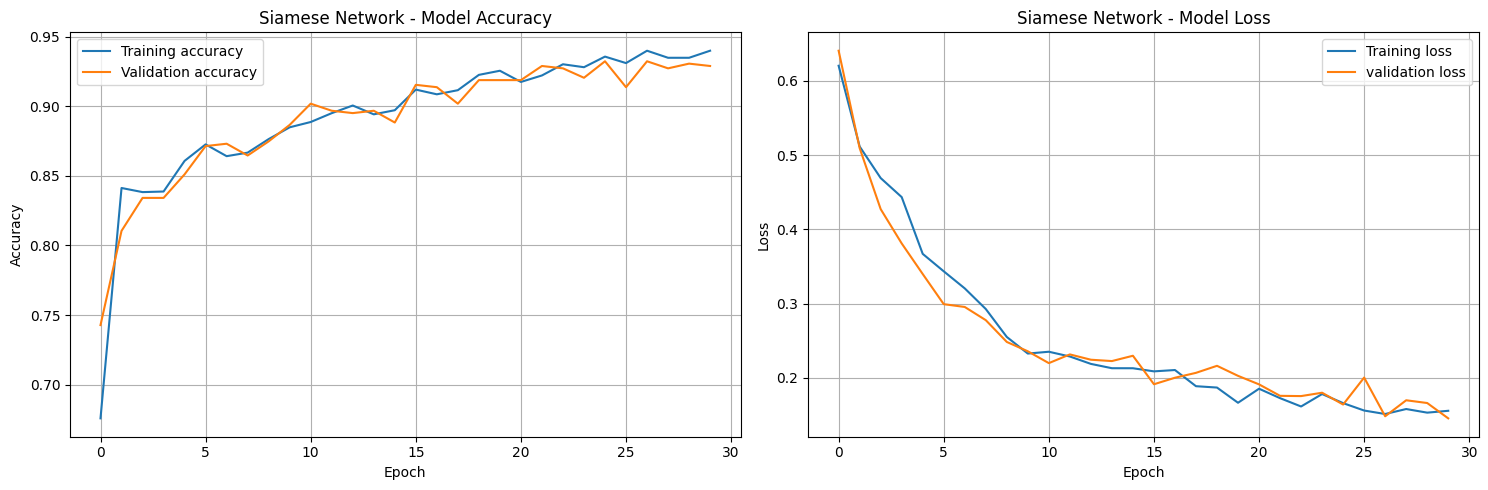

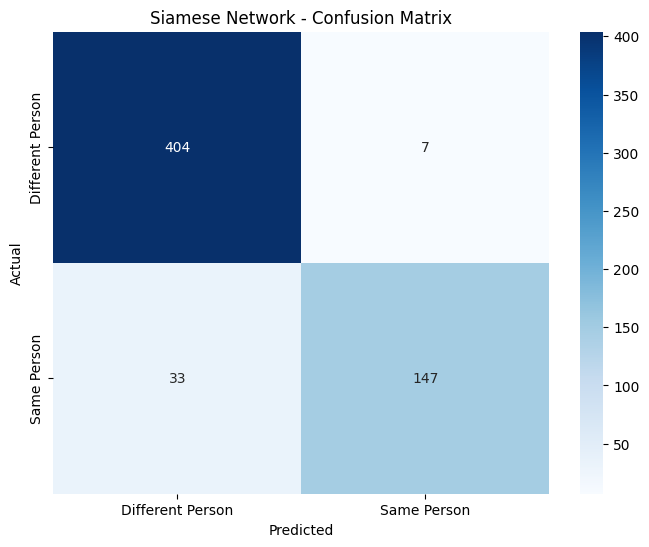

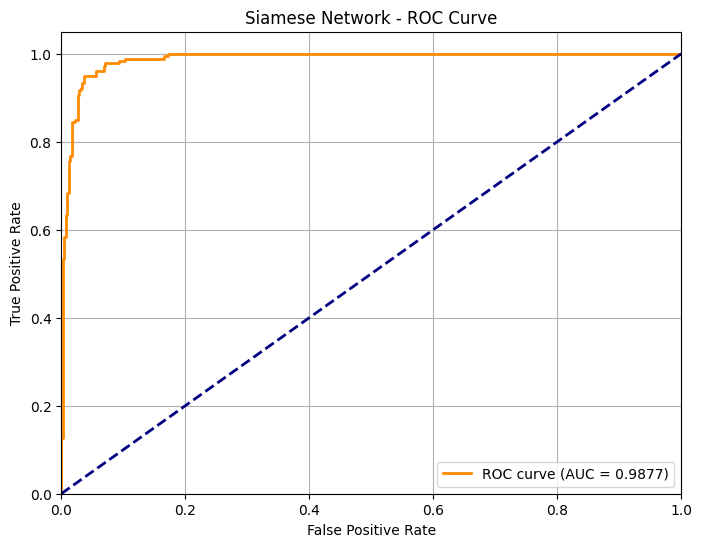

In [ ]:
results_base = siamese_vgg16.evaluate_model(X_val_a, X_val_b, y_val)

In [ ]:
siamese_vgg16.test_model(test_base_path)

Creating positive pairs...
Wanted person 27: 2 images -> 1 pairs
Wanted person 22: 2 images -> 1 pairs
Wanted person 21: 2 images -> 1 pairs
Wanted person 11: 2 images -> 1 pairs
Wanted person 06: 2 images -> 1 pairs
Wanted person 05: 2 images -> 1 pairs
Wanted person 01: 2 images -> 1 pairs
Wanted person 02: 2 images -> 1 pairs
Total positive pairs: 8

Creating negative pairs...
Cross-category (wanted vs unwanted): 138 pairs
Different wanted persons: 245 pairs
Different unwanted persons: 15 pairs
Total negative pairs: 398
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 526ms/step

*** Testing results ***
Accuracy: 0.9458 (94.58%)


In [ ]:
base_model_path = 'siamese_vgg_base_lightweight.h5'
siamese_vgg16.model.save(base_model_path)

In [ ]:
import gc

data_novel_path = '/content/drive/MyDrive/ĐATN/data_novel/train'
test_novel_path = '/content/drive/MyDrive/ĐATN/data_novel/test'

# del siamese_vgg16
tf.keras.backend.clear_session()
gc.collect()

X_val_a_novel, X_val_b_novel, y_val_novel = siamese_vgg16.fine_tune(
    data_novel_path,
    epochs = 30,
    batch_size = 32,
    use_enhanced_pairs = True,
    augmentation_factor = 2,
    negative_multiplier = 3,
    fine_tune_lr = 1e-5
)

Positive pairs created: 63
Augmenting positive pairs with factor 2
Augmentation iteration 1/1
Total positive pairs after augmentation: 126
  Creating 126 unwanted vs unwanted pairs...
Negative pairs created: 378
Total pairs: 504
Positive/Negative ratio: 126/378 = 0.33
Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 916ms/step - accuracy: 0.8172 - loss: 0.6353
Epoch 1: val_accuracy improved from -inf to 0.88119, saving model to best_siamese_vgg_finetuned.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8165 - loss: 0.6409 - val_accuracy: 0.8812 - val_loss: 1.0579 - learning_rate: 1.0000e-05
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7688 - loss: 0.8159
Epoch 2: val_accuracy did not improve from 0.88119
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 437ms/step - accuracy: 0.7688 - loss: 0.8141 - val_accuracy: 0.8812 - val_loss: 1.0078 - learning_rate: 1.0000e-05
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7850 - loss: 0.8079
Epoch 3: val_accuracy did not improve from 0.88119
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 435ms/step - accuracy: 0.7862 - loss: 0.7975 - val_accuracy: 0.8812 - val_loss: 0.9687 - learning_rate: 1.0000e-05
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.7996 - loss: 0.8974
Epoch 4: val_accuracy did not improve from 0.88119
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 434ms/step - accuracy: 0.8005 - loss: 0.8829 - val_accuracy: 0.8812 - val_loss: 0.9328 - learning_rate: 1.0000e-05
Epoch 5/3

13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.7878 - loss: 0.6985 - val_accuracy: 0.8911 - val_loss: 0.8419 - learning_rate: 1.0000e-05
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8332 - loss: 0.5305
Epoch 8: val_accuracy did not improve from 0.89109
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 500ms/step - accuracy: 0.8313 - loss: 0.5361 - val_accuracy: 0.8911 - val_loss: 0.8169 - learning_rate: 1.0000e-05
Epoch 9/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8187 - loss: 0.4993
Epoch 9: val_accuracy did not improve from 0.89109
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 432ms/step - accuracy: 0.8178 - loss: 0.5043 - val_accuracy: 0.8911 - val_loss: 0.7918 - learning_rate: 1.0000e-05
Epoch 10/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7874 - loss: 0.6312
Epoch 10: val_accuracy did not improve from 0.89109
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 441ms/step - accuracy: 0.7876 - loss: 0.6282 - val_accuracy: 0.8911 - val_loss: 0.7706 - learning_rate: 1.0000e-05
Epoch

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 561ms/step
*** Siamese Network (VGG16 based) results ***
Accuracy: 0.8911
Precision: 1.0000
Recall: 0.5600
F1-Score: 0.7179
AUC-ROC: 0.8153


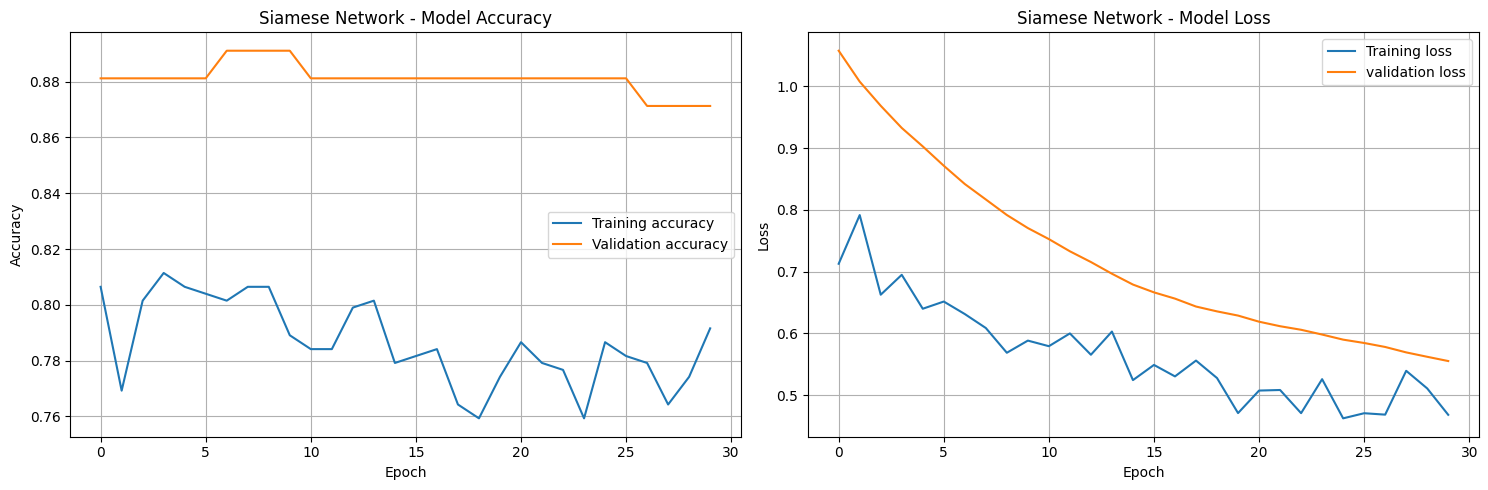

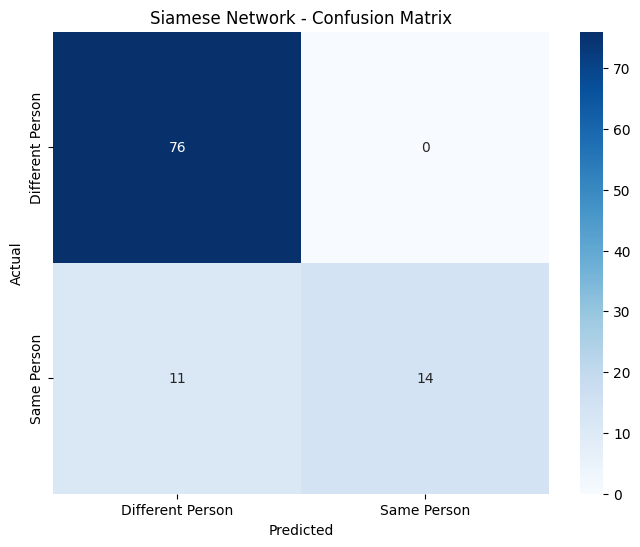

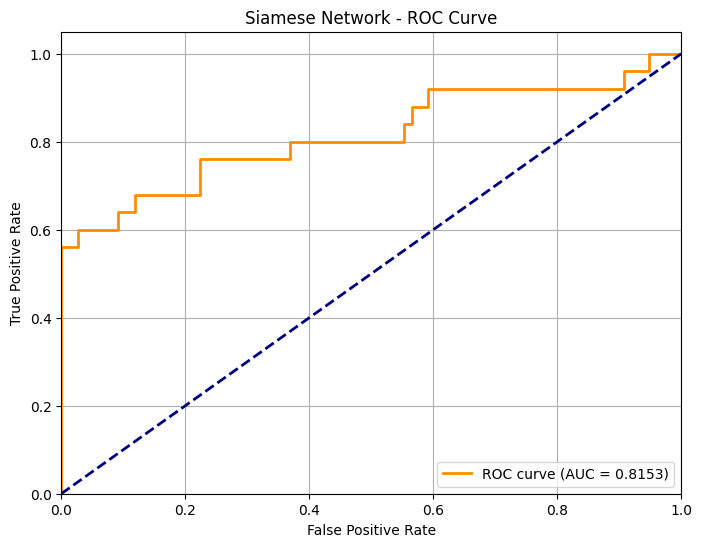

In [ ]:
results_novel = siamese_vgg16.evaluate_model(X_val_a_novel, X_val_b_novel, y_val_novel)

In [ ]:
siamese_vgg16.test_model(test_novel_path)

Creating positive pairs...
Wanted person 28: 3 images -> 3 pairs
Wanted person 26: 5 images -> 10 pairs
Wanted person 30: 5 images -> 10 pairs
Wanted person 23: 7 images -> 21 pairs
Wanted person 24: 6 images -> 15 pairs
Wanted person 25: 4 images -> 6 pairs
Wanted person 18: 4 images -> 6 pairs
Wanted person 15: 2 images -> 1 pairs
Wanted person 13: 4 images -> 6 pairs
Wanted person 16: 4 images -> 6 pairs
Wanted person 14: 4 images -> 6 pairs
Wanted person 12: 4 images -> 6 pairs
Wanted person 17: 2 images -> 1 pairs
Wanted person 07: 3 images -> 3 pairs
Wanted person 08: 4 images -> 6 pairs
Unwanted person 10: 2 images -> 1 pairs
Unwanted person 11: 2 images -> 1 pairs
Total positive pairs: 108

Creating negative pairs...
Cross-category (wanted vs unwanted): 488 pairs
Different wanted persons: 1724 pairs
Different unwanted persons: 26 pairs
Total negative pairs: 2238
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 157ms/step

*** Testing results ***
Accuracy: 0.8964 (89.64%)


In [ ]:
final_model_path = 'siamese_vgg_novel.h5'
siamese_vgg16.model.save(final_model_path)